In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import math
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', None)

In [3]:
trainFolder = os.fsencode("seasons/train")
testFolder = os.fsencode("seasons/test")

In [4]:
dataframes = []
for file in sorted(os.listdir(testFolder)):
    filename = os.fsdecode(file)
    if filename.endswith(".csv"):
        print(filename)
        df = pd.read_csv("seasons/test/" + filename)
        dataframes.append(df)

testData = pd.concat(dataframes, axis=0)

2223.csv
2324.csv
2425.csv
2526.csv


In [5]:
dataframes = []
for file in sorted(os.listdir(trainFolder)):
    filename = os.fsdecode(file)
    if filename.endswith(".csv"):
        print(filename)
        df = pd.read_csv("seasons/train/" + filename)
        dataframes.append(df)

trainData = pd.concat(dataframes, axis=0)

0607.csv
0708.csv
0809.csv
0910.csv
1011.csv
1112.csv
1213.csv
1314.csv
1415.csv
1516.csv
1617.csv
1718.csv
1819.csv
1920.csv
2021.csv
2122.csv


In [6]:
print(trainData.columns)

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR',
       ...
       'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH',
       'MaxCAHA', 'AvgCAHH', 'AvgCAHA'],
      dtype='object', length=139)


In [7]:
trainData = trainData[[
    "Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HS", "AS", "HST", "AST", 
]]

In [8]:
trainData["HomeLast3"] = trainData.groupby('HomeTeam')['FTHG'].transform(
    lambda x: x.shift().rolling(window=3, min_periods=3).sum()
) - trainData.groupby("HomeTeam")["FTAG"].transform(
    lambda x: x.shift().rolling(window=3, min_periods=3).sum()
)
trainData["AwayLast3"] = trainData.groupby('AwayTeam')['FTAG'].transform(
    lambda x: x.shift().rolling(window=3, min_periods=3).sum()
) - trainData.groupby("AwayTeam")["FTHG"].transform(
    lambda x: x.shift().rolling(window=3, min_periods=3).sum()
)

In [9]:
trainData["MatchRating"] = trainData["HomeLast3"] - trainData["AwayLast3"]

In [10]:
trainData.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HomeLast3,AwayLast3,MatchRating
375,22/05/2022,Crystal Palace,Man United,1.0,0.0,H,6.0,10.0,3.0,4.0,4.0,-10.0,14.0
376,22/05/2022,Leicester,Southampton,4.0,1.0,H,12.0,7.0,6.0,2.0,2.0,-5.0,7.0
377,22/05/2022,Liverpool,Wolves,3.0,1.0,H,29.0,7.0,8.0,5.0,6.0,-2.0,8.0
378,22/05/2022,Man City,Aston Villa,3.0,2.0,H,24.0,4.0,5.0,2.0,12.0,1.0,11.0
379,22/05/2022,Norwich,Tottenham,0.0,5.0,A,9.0,19.0,0.0,13.0,-5.0,4.0,-9.0


In [11]:
trainData["HomeWin"] = np.where(trainData["FTR"] == "H", 1, 0)
trainData["Draw"] = np.where(trainData["FTR"] == "D", 1, 0)
trainData["AwayWin"] = np.where(trainData["FTR"] == "A", 1, 0)

In [12]:
trainData = trainData.dropna()
trainData.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HomeLast3,AwayLast3,MatchRating,HomeWin,Draw,AwayWin
375,22/05/2022,Crystal Palace,Man United,1.0,0.0,H,6.0,10.0,3.0,4.0,4.0,-10.0,14.0,1,0,0
376,22/05/2022,Leicester,Southampton,4.0,1.0,H,12.0,7.0,6.0,2.0,2.0,-5.0,7.0,1,0,0
377,22/05/2022,Liverpool,Wolves,3.0,1.0,H,29.0,7.0,8.0,5.0,6.0,-2.0,8.0,1,0,0
378,22/05/2022,Man City,Aston Villa,3.0,2.0,H,24.0,4.0,5.0,2.0,12.0,1.0,11.0,1,0,0
379,22/05/2022,Norwich,Tottenham,0.0,5.0,A,9.0,19.0,0.0,13.0,-5.0,4.0,-9.0,0,0,1


In [13]:
trainData.groupby(by="MatchRating").mean(numeric_only=True)

,FTHG,FTAG,HS,AS,HST,AST,HomeLast3,AwayLast3,HomeWin,Draw,AwayWin
MatchRating,,,,,,,,,,,
-17.0,2.000000,3.000000,13.000000,16.000000,7.000000,4.000000,-8.000000,9.000000,0.000000,0.000000,1.000000
-15.0,1.000000,3.500000,10.500000,15.000000,4.500000,6.000000,-9.000000,6.000000,0.000000,0.500000,0.500000
-14.0,1.250000,2.750000,9.500000,12.500000,2.750000,5.750000,-6.500000,7.500000,0.000000,0.250000,0.750000
-13.0,0.571429,3.142857,9.571429,19.000000,4.142857,8.857143,-6.857143,6.142857,0.142857,0.000000,0.857143
-12.0,0.888889,2.555556,10.666667,14.666667,3.666667,7.777778,-5.444444,6.555556,0.222222,0.000000,0.777778
-11.0,1.117647,2.117647,10.058824,15.352941,3.176471,6.000000,-4.882353,6.117647,0.235294,0.058824,0.705882
-10.0,0.956522,1.652174,9.478261,14.695652,4.000000,5.434783,-4.739130,5.260870,0.217391,0.260870,0.521739
-9.0,0.953488,2.069767,11.116279,15.395349,4.023256,6.627907,-4.651163,4.348837,0.139535,0.302326,0.558140
-8.0,0.918033,1.672131,11.836066,14.147541,4.196721,5.639344,-3.524590,4.475410,0.213115,0.163934,0.622951


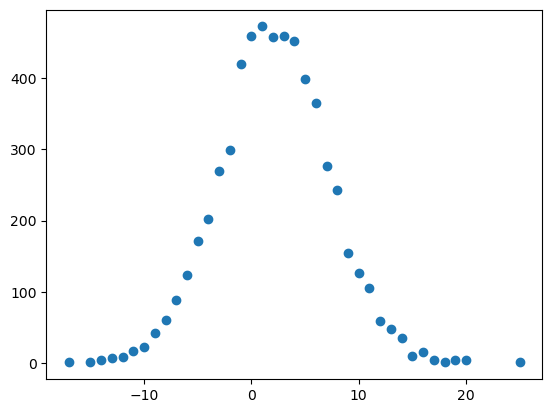

In [14]:
fig, ax = plt.subplots()
ax.scatter(trainData.groupby(by="MatchRating").count().index, trainData.groupby(by="MatchRating").count()["Date"])

In [15]:
testData["HomeLast3"] = testData.groupby('HomeTeam')['FTHG'].transform(
    lambda x: x.shift().rolling(window=3, min_periods=3).sum()
) - testData.groupby("HomeTeam")["FTAG"].transform(
    lambda x: x.shift().rolling(window=3, min_periods=3).sum()
)
testData["AwayLast3"] = testData.groupby('AwayTeam')['FTAG'].transform(
    lambda x: x.shift().rolling(window=3, min_periods=3).sum()
) - testData.groupby("AwayTeam")["FTHG"].transform(
    lambda x: x.shift().rolling(window=3, min_periods=3).sum()
)

testData["MatchRating"] = testData["HomeLast3"] - testData["AwayLast3"]

testData["HomeWin"] = np.where(testData["FTR"] == "H", 1, 0)
testData["Draw"] = np.where(testData["FTR"] == "D", 1, 0)
testData["AwayWin"] = np.where(testData["FTR"] == "A", 1, 0)

In [16]:
# make fair odds! For Home wins and Away wins only

In [17]:
groupedByRating = trainData.groupby(by="MatchRating").mean(numeric_only=True)
groupedByRating = groupedByRating[trainData.groupby(by="MatchRating").count()["Date"] > 120]
groupedByRating = groupedByRating[[
    "FTHG", "FTAG", "HS", "AS", "HomeWin", "Draw", "AwayWin"
]]
groupedByRating = groupedByRating.reset_index()

In [18]:
X = groupedByRating[["MatchRating"]]
Home = groupedByRating["HomeWin"]
Away = groupedByRating[["AwayWin"]]

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
model = linear_model.LinearRegression()
model.fit(X_poly, Home)
homePred = model.predict(X_poly)

homeX2 = model.coef_[2]
homeX = model.coef_[1]
homeIntercept = model.intercept_

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
model = linear_model.LinearRegression()
model.fit(X_poly, Away)
awayPred = model.predict(X_poly)

awayX2 = model.coef_[0][2]
awayX = model.coef_[0][1]
awayIntercept = model.intercept_

In [19]:
#plt.scatter(X, Y, color='blue', label="Original Data")
#plt.plot(X, y_pred, color='red', label="Polynomial Fit")
#plt.xlabel("X")
#plt.ylabel("y")
#plt.legend()
#plt.show()

In [20]:
testData["FairHomeOdds"] = 1 / (homeX2 * testData["MatchRating"]**2 + homeX * testData["MatchRating"] + homeIntercept)
testData["FairAwayOdds"] = 1 / (awayX2 * testData["MatchRating"]**2 + awayX * testData["MatchRating"] + awayIntercept)

In [21]:
testData = testData[[
    "Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HS", "AS", "MaxH", "MaxD", "MaxA", 
    "HomeLast3", "AwayLast3", "MatchRating", "HomeWin", "Draw", "AwayWin", "FairHomeOdds", "FairAwayOdds"
]]

testData = testData[(testData["MatchRating"] >= -7) & (testData["MatchRating"] <= 12)]
testData.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,MaxH,MaxD,MaxA,HomeLast3,AwayLast3,MatchRating,HomeWin,Draw,AwayWin,FairHomeOdds,FairAwayOdds
85,26/10/2025,Arsenal,Crystal Palace,1,0,H,10,7,1.44,4.75,8.70,5.0,3.0,2.0,1,0,0,2.251739,3.464682
86,26/10/2025,Aston Villa,Man City,1,0,H,9,18,4.33,4.00,1.89,0.0,0.0,0.0,1,0,0,2.479448,3.034736
87,26/10/2025,Bournemouth,Nott'm Forest,2,0,H,13,8,1.81,3.95,4.60,3.0,-5.0,8.0,1,0,0,1.704230,5.259525
88,26/10/2025,Wolves,Burnley,2,3,A,15,11,2.00,3.40,4.25,-3.0,-6.0,3.0,0,0,1,2.147010,3.707930
89,26/10/2025,Everton,Tottenham,0,3,A,12,7,2.40,3.40,3.15,1.0,4.0,-3.0,0,0,1,2.869555,2.509974


In [22]:
testData["HomeBet"] = np.where(testData['MaxH'] > testData["FairHomeOdds"], 1, 0)
testData["AwayBet"] = np.where(testData['MaxA'] > testData["FairAwayOdds"], 1, 0)

In [23]:
testData.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,MaxH,MaxD,MaxA,HomeLast3,AwayLast3,MatchRating,HomeWin,Draw,AwayWin,FairHomeOdds,FairAwayOdds,HomeBet,AwayBet
85,26/10/2025,Arsenal,Crystal Palace,1,0,H,10,7,1.44,4.75,8.70,5.0,3.0,2.0,1,0,0,2.251739,3.464682,0,1
86,26/10/2025,Aston Villa,Man City,1,0,H,9,18,4.33,4.00,1.89,0.0,0.0,0.0,1,0,0,2.479448,3.034736,1,0
87,26/10/2025,Bournemouth,Nott'm Forest,2,0,H,13,8,1.81,3.95,4.60,3.0,-5.0,8.0,1,0,0,1.704230,5.259525,1,0
88,26/10/2025,Wolves,Burnley,2,3,A,15,11,2.00,3.40,4.25,-3.0,-6.0,3.0,0,0,1,2.147010,3.707930,0,1
89,26/10/2025,Everton,Tottenham,0,3,A,12,7,2.40,3.40,3.15,1.0,4.0,-3.0,0,0,1,2.869555,2.509974,0,1


In [24]:
testData["Profit"] = testData["HomeWin"] * testData["HomeBet"] * testData["MaxH"] + testData["AwayWin"] * testData["AwayBet"] * testData["MaxA"] - (testData["HomeBet"] + testData["AwayBet"])

In [25]:
testData.tail(n=15)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,MaxH,MaxD,MaxA,HomeLast3,AwayLast3,MatchRating,HomeWin,Draw,AwayWin,FairHomeOdds,FairAwayOdds,HomeBet,AwayBet,Profit
75,18/10/2025,Sunderland,Wolves,2,0,H,8,16,2.50,3.15,3.25,4.0,-2.0,6.0,1,0,0,1.866260,4.567600,1,0,1.50
76,18/10/2025,Fulham,Arsenal,0,1,A,9,16,6.50,4.40,1.57,3.0,1.0,2.0,0,0,1,2.251739,3.464682,1,0,-1.00
77,19/10/2025,Tottenham,Aston Villa,1,2,A,9,8,2.15,3.70,3.50,2.0,-1.0,3.0,0,0,1,2.147010,3.707930,1,0,-1.00
78,19/10/2025,Liverpool,Man United,1,2,A,19,12,1.62,4.70,5.10,4.0,-5.0,9.0,0,0,1,1.629947,5.642027,0,0,0.00
79,20/10/2025,West Ham,Brentford,0,2,A,7,22,2.50,3.55,2.95,-8.0,-5.0,-3.0,0,0,1,2.869555,2.509974,0,1,1.95
80,24/10/2025,Leeds,West Ham,2,1,H,13,9,1.83,3.65,5.00,-1.0,1.0,-2.0,1,0,0,2.732867,2.670663,0,1,-1.00
81,25/10/2025,Chelsea,Sunderland,1,2,A,16,10,1.42,5.25,9.50,1.0,-1.0,2.0,0,0,1,2.251739,3.464682,0,1,8.50
82,25/10/2025,Newcastle,Fulham,2,1,H,18,12,1.64,4.10,6.00,2.0,-6.0,8.0,1,0,0,1.704230,5.259525,0,1,-1.00
83,25/10/2025,Man United,Brighton,4,2,H,13,17,2.05,4.00,3.60,4.0,1.0,3.0,1,0,0,2.147010,3.707930,0,0,0.00
84,25/10/2025,Brentford,Liverpool,3,2,H,17,18,4.50,4.20,1.78,1.0,-1.0,2.0,1,0,0,2.251739,3.464682,1,0,3.50


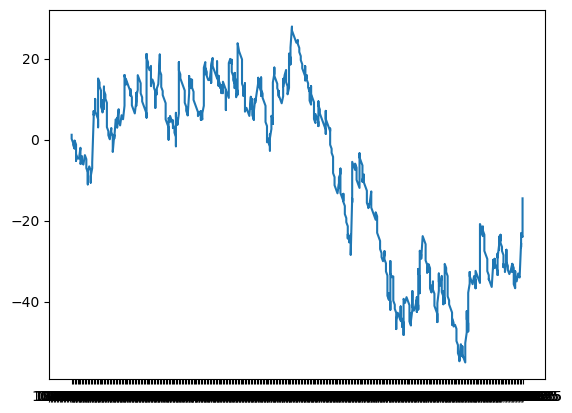

In [26]:
fig, ax = plt.subplots()
ax.plot(testData["Date"], testData["Profit"].cumsum())

In [27]:
testData["HomeBet"].sum() + testData["AwayBet"].sum() 

980

In [28]:
testData["Profit"].sum()

-14.510000000000016

In [29]:
testData["Profit"].count()

967

In [30]:
profits = testData["Profit"].tolist()

In [31]:
totalBets = sum(testData["HomeBet"].tolist()) + sum(testData["AwayBet"].tolist())

In [32]:
totalBets

980

In [33]:
cleanProfits = [x for x in profits if not math.isnan(x)]

In [34]:
print(cleanProfits)

[1.1800000000000002, -1.0, -1.0, -0.45999999999999996, -1.0, 2.05, -1.0, -1.0, -1.0, -1.0, -1.0, 2.55, -1.0, -1.0, 0.0, 2.65, -1.0, -1.0, -1.0, -1.0, 1.17, -1.0, 1.69, -1.0, -1.0, 2.33, -1.0, -1.0, -0.21999999999999997, -1.0, -1.0, -1.0, -1.0, -1.0, 3.0999999999999996, 1.3399999999999999, -1.0, -1.0, -1.0, -1.0, 1.56, 2.0, 1.4, 11.0, 1.69, -1.0, 1.23, 2.77, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 2.17, 1.0, 0.8799999999999999, -1.0, 9.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 2.61, -1.0, -1.0, -1.0, 1.94, -1.0, 2.27, -1.0, 2.75, 1.42, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 2.78, -1.0, -1.0, -1.0, 0.08999999999999986, -1.0, -1.0, -1.0, 4.25, -1.0, 4.8, -1.0, -1.0, 2.3, -1.0, 3.2, -1.0, -1.0, -1.0, -1.0, 2.52, -1.0, 3.3600000000000003, 2.55, 2.4, 0.7999999999999998, 1.7999999999999998, -0.29000000000000004, -1.0, -1.0, 1.2400000000000002, -1.0, -1.0, -1.0, -1.0, 1.58, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 2.95, 0.94, -1.0, -1.0, 3.2, -1.0, 

In [35]:
import csv


with open("profits.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(cleanProfits)

In [36]:
testData.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,MaxH,MaxD,MaxA,HomeLast3,AwayLast3,MatchRating,HomeWin,Draw,AwayWin,FairHomeOdds,FairAwayOdds,HomeBet,AwayBet,Profit
85,26/10/2025,Arsenal,Crystal Palace,1,0,H,10,7,1.44,4.75,8.70,5.0,3.0,2.0,1,0,0,2.251739,3.464682,0,1,-1.00
86,26/10/2025,Aston Villa,Man City,1,0,H,9,18,4.33,4.00,1.89,0.0,0.0,0.0,1,0,0,2.479448,3.034736,1,0,3.33
87,26/10/2025,Bournemouth,Nott'm Forest,2,0,H,13,8,1.81,3.95,4.60,3.0,-5.0,8.0,1,0,0,1.704230,5.259525,1,0,0.81
88,26/10/2025,Wolves,Burnley,2,3,A,15,11,2.00,3.40,4.25,-3.0,-6.0,3.0,0,0,1,2.147010,3.707930,0,1,3.25
89,26/10/2025,Everton,Tottenham,0,3,A,12,7,2.40,3.40,3.15,1.0,4.0,-3.0,0,0,1,2.869555,2.509974,0,1,2.15


In [37]:
homeTeam = "Sunderland"
home = testData[testData["HomeTeam"] == homeTeam].tail(n=3)["FTHG"].sum() - testData[testData["HomeTeam"] == homeTeam].tail(n=3)["FTAG"].sum()
home

2

In [38]:
awayTeam = "Everton"
away = testData[testData["AwayTeam"] == awayTeam].tail(n=3)["FTAG"].sum() - testData[testData["AwayTeam"] == awayTeam].tail(n=3)["FTHG"].sum()
away

-2

In [39]:
rating = home - away
rating

4

In [40]:
print(f"Home Win Probability: {homeX2 * rating**2 + homeX * rating + homeIntercept}")
print(f"Away Win Probability: {awayX2 * rating**2 + awayX * rating + awayIntercept}")

Home Win Probability: 0.48827310218695263
Away Win Probability: [0.25176522]
